# Reinforcement learning

In [30]:
import numpy as np
import keras_tuner
import keras
import pandas as pd
import tensorflow as tf
from dataclasses import dataclass

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

pd.options.display.max_columns = 200
keras.utils.set_random_seed(42)

In [31]:
@dataclass
class ProcessedData:
  def __init__(self, X, y):
    self.X = X.copy()
    self.y = y.copy(deep=True)

  def copy(self):
    return ProcessedData(self.X.copy(), self.y.copy())

In [33]:
#X = pd.read_csv("./data/15/X.csv", header=None).iloc[: , 1:]
y = pd.read_csv("./data/17/y.csv", header=None)
X = pd.read_csv("./data/17/diff.csv", header=None)
print(y.shape)
#print(X.shape)
print(X.shape)

(10735, 1)
(10735, 2040)


In [34]:
y.groupby(0)[0].count()

0
0    8583
1     898
2    1254
Name: 0, dtype: int64

In [37]:
import numpy as np
import cv2
import os

# Example array of image matrices
#data = X.to_numpy().reshape(-1, 40, 51, 1)
data = X_train

output_dir = "output_images"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for idx, img_matrix in enumerate(data):
      # Create an empty 3-channel image of the same dimensions
    rgb_image = np.zeros((img_matrix.shape[0], img_matrix.shape[1], 3), dtype=np.uint8)
    
    # Set the red channel to 255 wherever img_matrix is 1
    rgb_image[img_matrix[:, :, 0] == -1, 0] = 255
    
    # Set the blue channel to 255 wherever img_matrix is -1
    rgb_image[img_matrix[:, :, 0] == 1, 2] = 255
    
    filename = os.path.join(output_dir, f'image_{idx}.png')
    cv2.imwrite(filename, rgb_image)
    if idx > 50:
        break


print(f"Saved {len(data)} images to {output_dir}")

Saved 5211 images to output_images


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [7]:
smoteenn = SMOTEENN(random_state=42)
X_train, y_train = smoteenn.fit_resample(X_train, y_train)

In [8]:
X_train = X_train.to_numpy().reshape(-1, 40, 51, 1)
X_test = X_test.to_numpy().reshape(-1, 40, 51, 1)

In [9]:
X_train.shape

(5211, 40, 51, 1)

In [10]:
#diff_images = []

#for i in range(1, X_res_2D.shape[0]):
#    diff = X_res_2D[i] - X_res_2D[i-1]
#    diff_images.append(diff)

#diff_images_array = np.array(diff_images)
#y_res_2 = y_res.drop(index=y.index[0], axis=0)

In [11]:
#y_res_2.shape

In [12]:
#diff_images_array.shape

In [13]:
y_train.groupby(0)[0].count()

0
0     621
1    2350
2    2240
Name: 0, dtype: int64

# The dataset is not balanced

In [14]:
sklearn_class_weights = compute_class_weight(class_weight="balanced", classes=y_train[0].unique(), y=y_train[0])
class_weight = {}
for i, weight in enumerate(sklearn_class_weights):
    class_weight[i] = weight
    
print(class_weight)

{0: 2.7971014492753623, 1: 0.7391489361702127, 2: 0.7754464285714285}


In [15]:
#X_train, X_test, y_train, y_test = train_test_split(X_res_2D, y_res)

In [16]:
train = ProcessedData(X_train, y_train)
test = ProcessedData(X_test, y_test)

In [17]:
# Extension de la classe BayesianOptimization pour permettre l'accès aux historiques des modèles entrainés.
class BayesianOptimization(keras_tuner.BayesianOptimization):
    histories = {}

    # À la fin de chaque époque, on ajoute les métriques à l'historique de l'essai en cours
    def on_epoch_end(self, trial, model, epoch, logs=None):
        trial_id = trial.trial_id
        trial_history = self.histories.setdefault(trial_id, {})
        for metric, value in logs.items():
            trial_history.setdefault(metric, []).append(value)

In [18]:
def build_model(hp):
    
    input = Input(shape=(40, 51, 1))
    # Optimisation du réseau de neurone

    #if hp.Boolean("Dense", default=False):
    #    x = Flatten()(input)
    #    x = Dense(hp.Int(f'units_0', 8, 64, step=16), activation='relu')(x)
    #    for i in range(hp.Int('layers', 0, 4)):
    #        x = Dense(hp.Int(f'units_{str(i+1)}', 8, 64, step=16), activation='relu')(x)
    #else:abs
    x = Conv2D(hp.Int(f'filter_0', 3, 9, step=3), hp.Int(f'kernel_size_0', 3, 5, step=2), activation='relu')(input)
    for i in range(hp.Int('layers', 0, 4)):
        x = Conv2D(hp.Int(f'filter_{str(i+1)}', 3, 9, step=3), hp.Int(f'kernel_size_{str(i+1)}', 3, 9, step=2), activation='relu')(x)
        if hp.Boolean("WithMaxPool", default=False):
            x = MaxPooling2D(hp.Int(f'max_pool_size_{str(i+1)}', 2, 6, step=2), strides=hp.Int(f'max_pool_strides_{str(i+1)}', 1, 4, step=10), padding='same')(x)
    x = Flatten()(x)

    output = Dense(3, activation='softmax')(x)
    model = Model(input, output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    overwrite=True,
    max_trials=10)

early_stopping_cb = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=1, mode='max', baseline=None, restore_best_weights=True)
tuner.search(train.X, train.y, validation_split=0.2, epochs=1000, callbacks=[early_stopping_cb])

Trial 6 Complete [00h 01m 06s]
val_accuracy: 0.9942473769187927

Best val_accuracy So Far: 0.9971237182617188
Total elapsed time: 00h 04m 09s

Search: Running Trial #7

Value             |Best Value So Far |Hyperparameter
3                 |9                 |filter_0
3                 |5                 |kernel_size_0
0                 |1                 |layers
6                 |3                 |filter_1
3                 |3                 |kernel_size_1
True              |False             |WithMaxPool
4                 |None              |max_pool_size_1
1                 |None              |max_pool_strides_1
3                 |None              |filter_2
3                 |None              |kernel_size_2
2                 |None              |max_pool_size_2
1                 |None              |max_pool_strides_2
3                 |None              |filter_3
5                 |None              |kernel_size_3
2                 |None              |max_pool_size_3
1          

2023-10-04 18:47:27.506637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

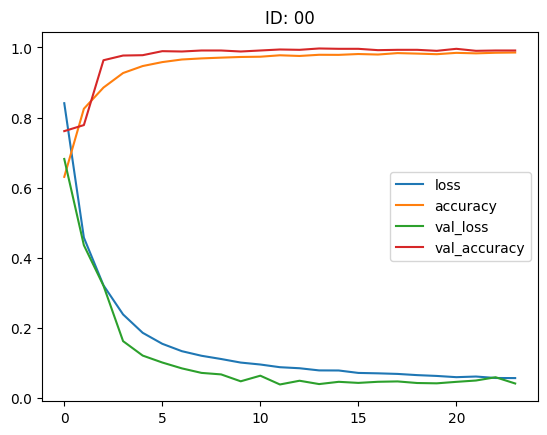

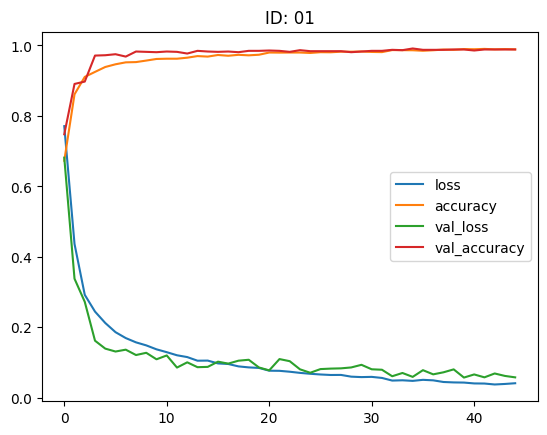

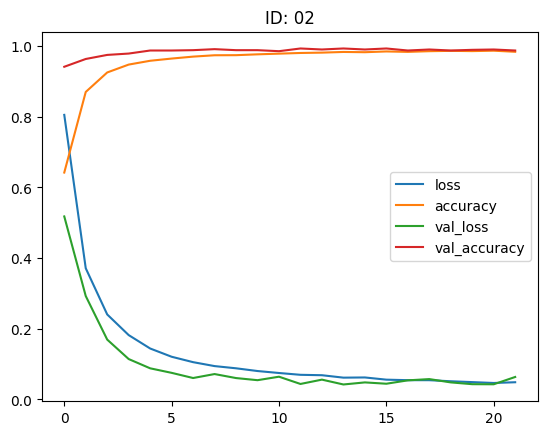

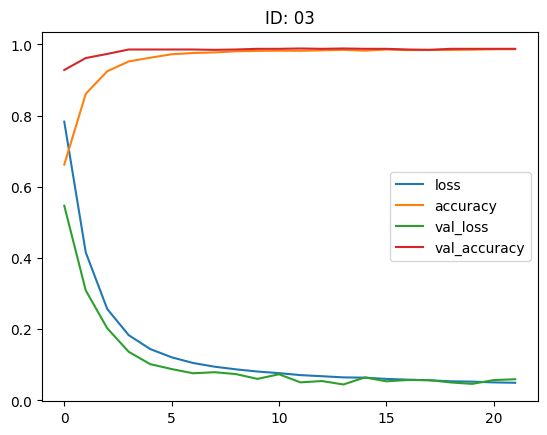

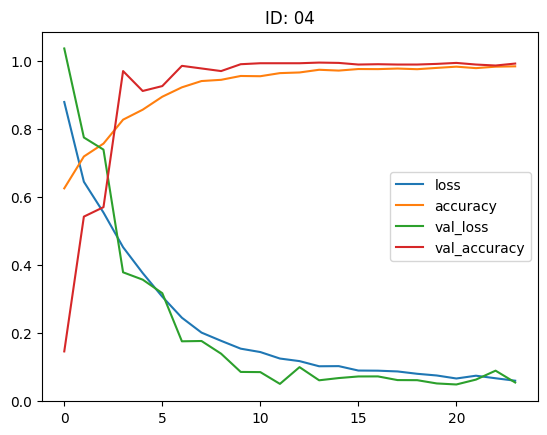

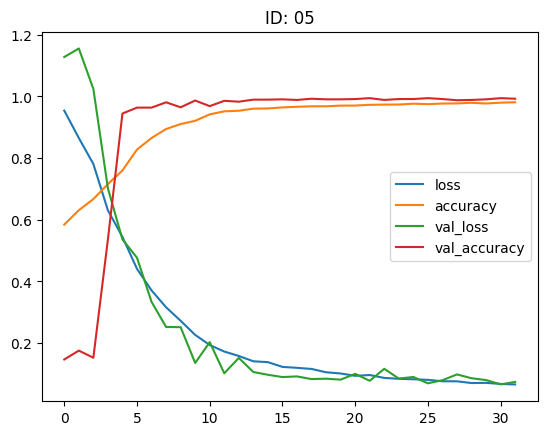

In [21]:
for id, history in tuner.histories.items():
    pd.DataFrame(history).plot(title=f"ID: {id}")

In [25]:
best_model = tuner.get_best_models()[0]

In [26]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 51, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 36, 47, 9)         234       
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 45, 3)         246       
                                                                 
 flatten (Flatten)           (None, 4590)              0         
                                                                 
 dense (Dense)               (None, 3)                 13773     
                                                                 
Total params: 14253 (55.68 KB)
Trainable params: 14253 (55.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


67/84 [======================>.......] - ETA: 0s

2023-10-04 18:48:59.591157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.89      0.30      0.45      2163
           1       0.16      0.65      0.26       206
           2       0.19      0.67      0.29       315

    accuracy                           0.37      2684
   macro avg       0.41      0.54      0.34      2684
weighted avg       0.75      0.37      0.42      2684



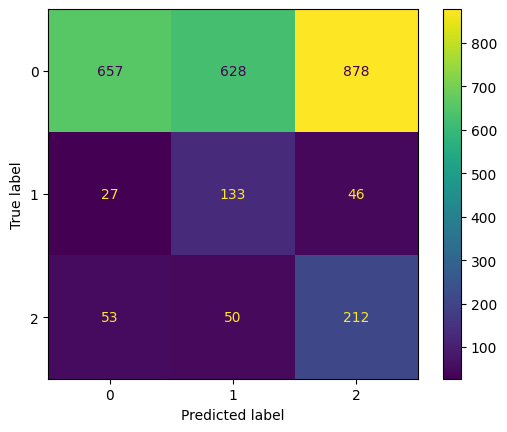

In [27]:
y_pred = best_model.predict(test.X)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(test.y, y_pred))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test.y, y_pred)).plot()

In [29]:
best_model.save(f"./models/pong-21.h5")

/Users/Sami/polytech/jupyter-env/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
